In [1]:
from gwpy.timeseries import TimeSeries
data1= TimeSeries.read('challenge3.gwf', 'H1:CHALLENGE3')
data2=TimeSeries.read('challenge3.gwf', 'L1:CHALLENGE3')

In [2]:
import numpy as np
signal1=np.array(data1)
signal2=np.array(data2)

In [3]:
from pycbc.frame import read_frame

ts_H1 = read_frame("challenge3.gwf", "H1:CHALLENGE3")

print("Duration_H1: {}s delta_t_H1: {}s sampling rate_H1: {}Hz Start_H1: {} End_H1: {}".format(ts_H1.duration, ts_H1.delta_t, 1/ts_H1.delta_t,
                                              int(ts_H1.start_time),
                                              int(ts_H1.end_time)))

ts_L1 = read_frame("challenge3.gwf", "L1:CHALLENGE3")

print("Duration_L1: {}s delta_t_L1: {}s sampling rate_L1: {}Hz Start_L1: {} End_L1: {}".format(ts_L1.duration, ts_L1.delta_t, 1/ts_L1.delta_t,
                                              int(ts_L1.start_time),
                                              int(ts_L1.end_time)))

Duration_H1: 4096.0s delta_t_H1: 0.000244140625s sampling rate_H1: 4096.0Hz Start_H1: 0 End_H1: 4096
Duration_L1: 4096.0s delta_t_L1: 0.000244140625s sampling rate_L1: 4096.0Hz Start_L1: 0 End_L1: 4096


In [4]:
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.catalog import Merger
from pycbc.psd import interpolate, inverse_spectrum_truncation

data_H1 = resample_to_delta_t(ts_H1, 1.0/2048).crop(2, 2)

p_H1 = data_H1.psd(2)
p_H1 = interpolate(p_H1, data_H1.delta_f)
p_H1 = inverse_spectrum_truncation(p_H1, 2 * data_H1.sample_rate, low_frequency_cutoff=15.0)
psd_H1 = p_H1

data_L1 = resample_to_delta_t(ts_L1, 1.0/2048).crop(2, 2)

p_L1 = data_L1.psd(2)
p_L1 = interpolate(p_L1, data_L1.delta_f)
p_L1 = inverse_spectrum_truncation(p_L1, 2 * data_L1.sample_rate, low_frequency_cutoff=15.0)
psd_L1 = p_L1
    

10
We found a possible signal candidate at 2483.96875s with SNR 28.636095483196648 in H1
We found a possible signal candidate at 2483.96875s with SNR 33.34123375597675 in L1
Peak Time is coincident in both detectors


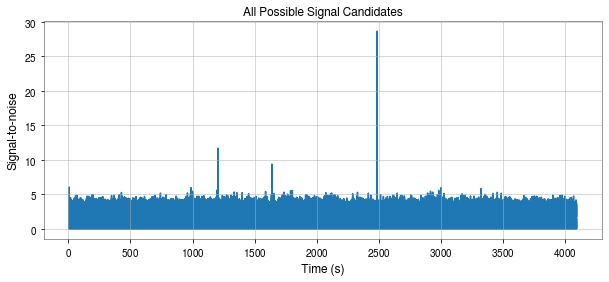

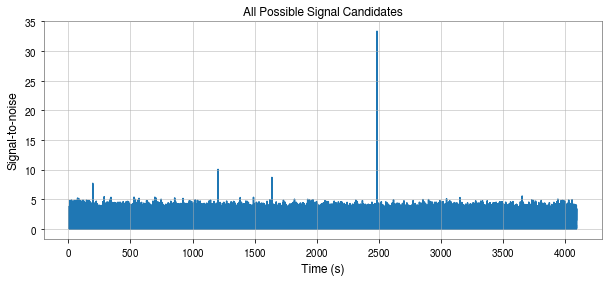

No handles with labels found to put in legend.


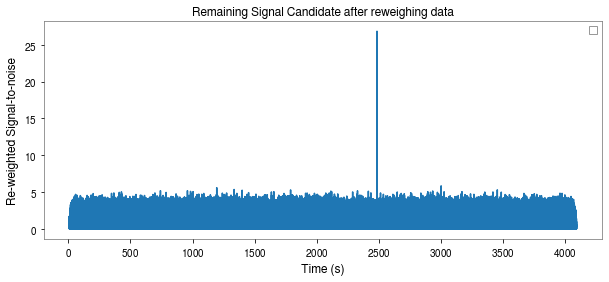

For the Hanford data we found a confirmed signal at 2483.96875s with SNR 26.83894692404073 after ruling out the other candidates as glitches


No handles with labels found to put in legend.


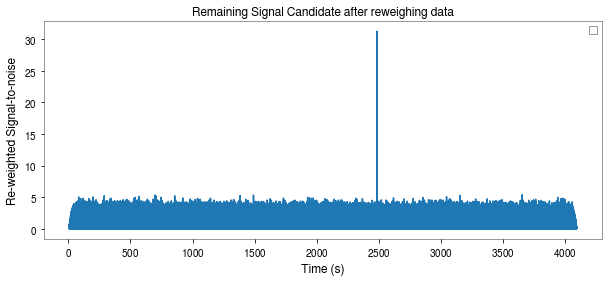

For the Livingston data we found a confirmed signal at 2483.96875s with SNR 31.238798653463096 after ruling out the other candidates as glitches
11
We found a possible signal candidate at 1204.71435546875s with SNR 12.01061227570686 in H1
We found a possible signal candidate at 2483.95849609375s with SNR 11.149996487569544 in L1


In [10]:
masses=[]
import pylab

for x in range(10,12):
  print(x)
  from pycbc.waveform import get_fd_waveform
  from pycbc.filter import matched_filter  
  hp1, _ = get_fd_waveform(approximant="IMRPhenomD",
                      mass1=x,
                      mass2=x,
                      delta_f=data_H1.delta_f,
                      f_lower=20.0)

  # We will resize the vector to match our data
  hp1.resize(len(psd_H1))
  #template1 = hp1.cyclic_time_shift(hp1.start_time)

  import numpy

  snr1 = matched_filter(hp1, data_H1,
                      psd=psd_H1, low_frequency_cutoff=20)


  snr1 = snr1.crop(5, 4)


  peak1 = abs(snr1).numpy().argmax()
  snrp1 = snr1[peak1]
  time1 = snr1.sample_times[peak1]

  
  print("We found a possible signal candidate at {}s with SNR {} in H1".format(time1, 
                                                      abs(snrp1)))
  hp2, _ = get_fd_waveform(approximant="IMRPhenomD",
                      mass1=x,
                      mass2=x,
                      delta_f=data_L1.delta_f,
                      f_lower=20.0)

  # We will resize the vector to match our data
  hp2.resize(len(psd_L1))
  #template2 = hp2.cyclic_time_shift(hp2.start_time)

  snr2 = matched_filter(hp2, data_L1,
                      psd=psd_L1, low_frequency_cutoff=20)


  snr2 = snr2.crop(5, 4)

  peak2 = abs(snr2).numpy().argmax()
  snrp2 = snr2[peak2]
  time2 = snr2.sample_times[peak2]

      
  print("We found a possible signal candidate at {}s with SNR {} in L1".format(time2, 
                                                      abs(snrp2)))
  if time1==time2:
    print("Peak Time is coincident in both detectors")
    
    pylab.figure(figsize=[10, 4])
    pylab.plot(snr1.sample_times, abs(snr1))
    pylab.title('All Possible Signal Candidates in H1')
    pylab.ylabel('Signal-to-noise')
    pylab.xlabel('Time (s)')
    pylab.show()
    
    pylab.figure(figsize=[10, 4])
    pylab.plot(snr2.sample_times, abs(snr2))
    pylab.title('All Possible Signal Candidates in L1')  
    pylab.ylabel('Signal-to-noise')
    pylab.xlabel('Time (s)')
    pylab.show()  
    
    
    from pycbc.vetoes import power_chisq

    #chisq = {}

    nbins = 26
    chisq_H1 = power_chisq(hp1, data_H1, nbins, psd_H1, low_frequency_cutoff=20.0)
    chisq_H1 = chisq_H1.crop(5, 4)
    
    dof = nbins * 2 - 2
    chisq_H1 /= dof
    
    chisq_L1 = power_chisq(hp2, data_L1, nbins, psd_L1, low_frequency_cutoff=20.0)
    chisq_L1 = chisq_L1.crop(5, 4)
    
    dof = nbins * 2 - 2
    chisq_L1 /= dof
    
    from pycbc.events.ranking import newsnr

    nsnr1 = newsnr(abs(snr1), chisq_H1)
    nsnr2 = newsnr(abs(snr2), chisq_L1)
    
    
    peak_H1 = nsnr1.argmax()
    snrp_H1 = nsnr1[peak_H1]
    time_H1 = snr1.sample_times[peak_H1]
    
    pylab.figure(figsize=[10, 4])
    pylab.plot(snr1.sample_times, nsnr1)    
    pylab.title('Remaining Signal Candidate in H1 after reweighing data')
    pylab.grid()    
    pylab.xlabel('Time (s)')
    pylab.ylabel('Re-weighted Signal-to-noise')
    pylab.show()
    
    print("For the Hanford data we found a confirmed signal at {}s with SNR {} after ruling out the other candidates as glitches".format(time_H1, 
                                                    abs(snrp_H1)))
    
    peak_L1 = nsnr2.argmax()
    snrp_L1 = nsnr2[peak_L1]
    time_L1 = snr2.sample_times[peak_L1]
    
    pylab.figure(figsize=[10, 4])
    pylab.plot(snr2.sample_times, nsnr2)
    pylab.title('Remaining Signal Candidate in L1 after reweighing data')
    pylab.grid()    
    pylab.xlabel('Time (s)')
    pylab.ylabel('Re-weighted Signal-to-noise')
    pylab.show()
    
    print("For the Livingston data we found a confirmed signal at {}s with SNR {} after ruling out the other candidates as glitches".format(time_L1, 
                                                    abs(snrp_L1)))
    
    masses.append(x)

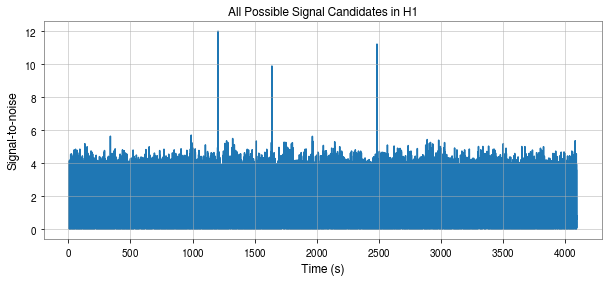

In [11]:
pylab.figure(figsize=[10, 4])
pylab.plot(snr1.sample_times, abs(snr1))
pylab.title('All Possible Signal Candidates in H1')
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

10


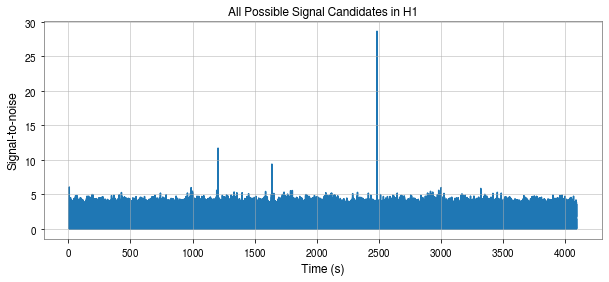

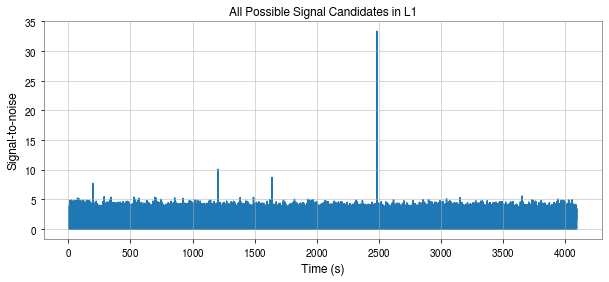

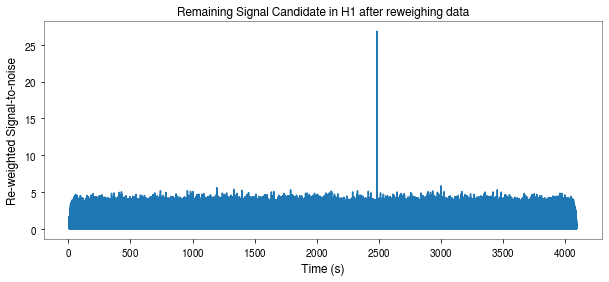

For the Hanford data we found a confirmed signal at 2483.96875s with SNR 26.83894692404073 after ruling out the other candidates as glitches


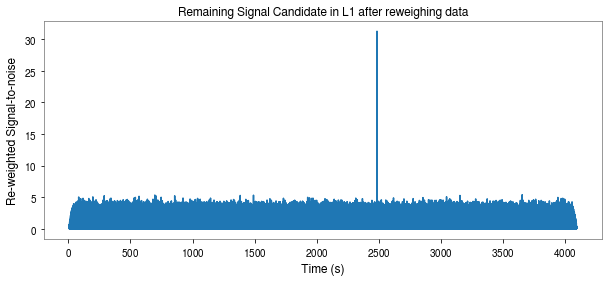

For the Livingston data we found a confirmed signal at 2483.96875s with SNR 31.238798653463096 after ruling out the other candidates as glitches
There is a confirmed signal detection at 2483.96875s for both the detectors for mass1=mass2 solar masses
11


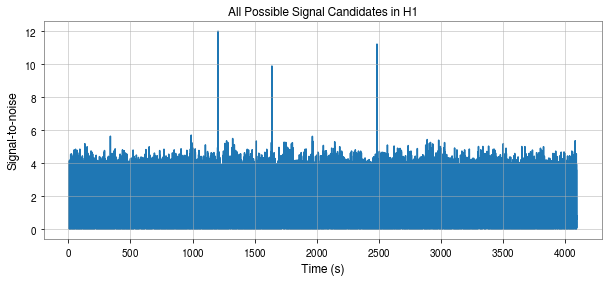

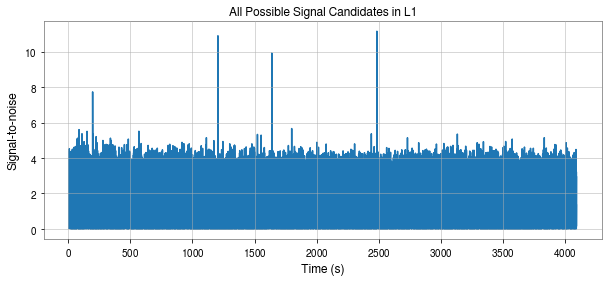

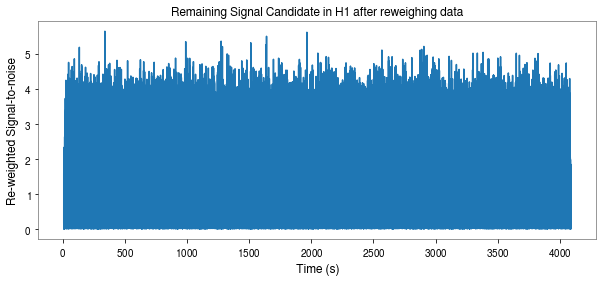

For the Hanford data we found a confirmed signal at 338.099609375s with SNR 5.635054611967112 after ruling out the other candidates as glitches


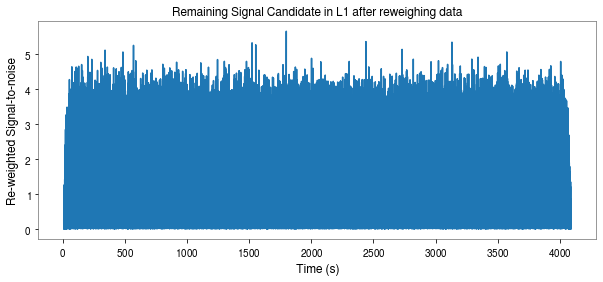

For the Livingston data we found a confirmed signal at 1798.38623046875s with SNR 5.661873033771894 after ruling out the other candidates as glitches
There was no simultaneous detection in H1 and L1 hence we rule out any authentic GW detection


In [18]:
masses=[]
import pylab
from colorama import Fore, Back, Style

for x in range(10,12):
  print(x)
  from pycbc.waveform import get_fd_waveform
  from pycbc.filter import matched_filter  
  hp1, _ = get_fd_waveform(approximant="IMRPhenomD",
                      mass1=x,
                      mass2=x,
                      delta_f=data_H1.delta_f,
                      f_lower=20.0)


  hp1.resize(len(psd_H1)) 
    
  import numpy

  snr1 = matched_filter(hp1, data_H1,
                      psd=psd_H1, low_frequency_cutoff=20)


  snr1 = snr1.crop(5, 4)


  peak1 = abs(snr1).numpy().argmax()
  snrp1 = snr1[peak1]
  time1 = snr1.sample_times[peak1]

  
  #print("We found a possible signal candidate at {}s with SNR {} in H1".format(time1, 
  #                                                    abs(snrp1)))
  hp2, _ = get_fd_waveform(approximant="IMRPhenomD",
                      mass1=x,
                      mass2=x,
                      delta_f=data_L1.delta_f,
                      f_lower=20.0)

  # We will resize the vector to match our data
  hp2.resize(len(psd_L1))

  snr2 = matched_filter(hp2, data_L1,
                      psd=psd_L1, low_frequency_cutoff=20)


  snr2 = snr2.crop(5, 4)

  peak2 = abs(snr2).numpy().argmax()
  snrp2 = snr2[peak2]
  time2 = snr2.sample_times[peak2]

      
  #print("We found a possible signal candidate at {}s with SNR {} in L1".format(time2, 
  #                                                    abs(snrp2)))
  #if time1==time2:
   # print("Peak Time is coincident in both detectors")
    
  pylab.figure(figsize=[10, 4])
  pylab.plot(snr1.sample_times, abs(snr1))
  pylab.title('All Possible Signal Candidates in H1')
  pylab.ylabel('Signal-to-noise')
  pylab.xlabel('Time (s)')
  pylab.show()
    
  pylab.figure(figsize=[10, 4])
  pylab.plot(snr2.sample_times, abs(snr2))
  pylab.title('All Possible Signal Candidates in L1')  
  pylab.ylabel('Signal-to-noise')
  pylab.xlabel('Time (s)')
  pylab.show()  
    
    
  from pycbc.vetoes import power_chisq

    #chisq = {}

  nbins = 26
  chisq_H1 = power_chisq(hp1, data_H1, nbins, psd_H1, low_frequency_cutoff=20.0)
  chisq_H1 = chisq_H1.crop(5, 4)
   
  dof = nbins * 2 - 2
  chisq_H1 /= dof
   
  chisq_L1 = power_chisq(hp2, data_L1, nbins, psd_L1, low_frequency_cutoff=20.0)
  chisq_L1 = chisq_L1.crop(5, 4)
   
  dof = nbins * 2 - 2
  chisq_L1 /= dof
    
  from pycbc.events.ranking import newsnr

  nsnr1 = newsnr(abs(snr1), chisq_H1)
  nsnr2 = newsnr(abs(snr2), chisq_L1)
    
    
  peak_H1 = nsnr1.argmax()
  snrp_H1 = nsnr1[peak_H1]
  time_H1 = snr1.sample_times[peak_H1]
    
  pylab.figure(figsize=[10, 4])
  pylab.plot(snr1.sample_times, nsnr1)    
  pylab.title('Remaining Signal Candidate in H1 after reweighing data')     
  pylab.xlabel('Time (s)')
  pylab.ylabel('Re-weighted Signal-to-noise')
  pylab.show()
  
  if peak_H1>7:
    print("For the Hanford data we found a confirmed signal at {}s with SNR {} after ruling out the other candidates as glitches".format(time_H1, abs(snrp_H1)))
    
  peak_L1 = nsnr2.argmax()
  snrp_L1 = nsnr2[peak_L1]
  time_L1 = snr2.sample_times[peak_L1]
    
  pylab.figure(figsize=[10, 4])
  pylab.plot(snr2.sample_times, nsnr2)
  pylab.title('Remaining Signal Candidate in L1 after reweighing data')      
  pylab.xlabel('Time (s)')
  pylab.ylabel('Re-weighted Signal-to-noise')
  pylab.show()
   
  if peak_L1>7:
    print("For the Livingston data we found a confirmed signal at {}s with SNR {} after ruling out the other candidates as glitches".format(time_L1, abs(snrp_L1)))
  
  
  if ((peak_L1>7 and peak_H1>7) and (time_H1==time_L1)):   
    print("There is a confirmed signal detection at {}s for both the detectors for mass1=mass2 solar masses".format(time_L1))   
  else:
    print("There was no simultaneous detection in H1 and L1 hence we rule out any authentic GW detection")
  
  masses.append(x)

In [19]:
from colorama import Fore, Back, Style
print(Fore.BLUE + 'some red text')

some red text


In [ ]:
massac=[]
import tensorflow as tf

for x in range(10,12):
  print(x)
  from pycbc.waveform import get_td_waveform
  hp1, hc1 = get_td_waveform(approximant="SEOBNRv4_opt",
                      mass1=x,
                      mass2=x,
                      delta_t=data_H1.delta_t,
                      f_lower=20)

  # We will resize the vector to match our data
  hp1.resize(len(data_H1))
  template1 = hp1.cyclic_time_shift(hp1.start_time)
  from pycbc.filter import matched_filter
  import numpy

  snr1 = matched_filter(template1, data_H1,
                      psd=psd_H1, low_frequency_cutoff=20)


  snr1 = snr1.crop(4 + 4, 4)


  peak1 = abs(snr1).numpy().argmax()
  snrp1 = snr1[peak1]
  time1 = snr1.sample_times[peak1]

  print("We found a possible signal candidate at {}s with SNR {} in H1".format(time1, 
                                                      abs(snrp1)))
  hp2, hc2 = get_td_waveform(approximant="SEOBNRv4_opt",
                      mass1=x,
                      mass2=x,
                      delta_t=data_L1.delta_t,
                      f_lower=20)

  # We will resize the vector to match our data
  hp2.resize(len(data_L1))
  template2 = hp2.cyclic_time_shift(hp2.start_time)

  snr2 = matched_filter(template2, data_L1,
                      psd=psd_L1, low_frequency_cutoff=20)


  snr2 = snr2.crop(4 + 4, 4)

  peak2 = abs(snr2).numpy().argmax()
  snrp2 = snr2[peak2]
  time2 = snr2.sample_times[peak2]

  print("We found a possible signal candidate at {}s with SNR {} in L1".format(time2, 
                                                      abs(snrp2)))
  if time1==time2:
    print("Peak Time is coincident in both detectors")
    from pycbc.filter import sigma
    dt1 = time1 - data_H1.start_time
    aligned1 = template1.cyclic_time_shift(dt1)

    # scale the template so that it would have SNR 1 in this data
    aligned1 /= sigma(aligned1, psd=psd_H1, low_frequency_cutoff=20.0)

    # Scale the template amplitude and phase to the peak value
    aligned1 = (aligned1.to_frequencyseries() * snrp1).to_timeseries()
    aligned1.start_time = data_H1.start_time
    # We do it this way so that we can whiten both the template and the data
    white_data1 = (data_H1.to_frequencyseries() / psd_H1**0.5).to_timeseries()

    # apply a smoothing of the turnon of the template to avoid a transient
    # from the sharp turn on in the waveform.
    tapered1 = aligned1.highpass_fir(30, 512, remove_corrupted=False)
    white_template1 = (tapered1.to_frequencyseries() / psd_H1**0.5).to_timeseries()

    white_data1 = white_data1.highpass_fir(30., 512).lowpass_fir(300, 512)
    white_template1 = white_template1.highpass_fir(30, 512).lowpass_fir(300, 512)

    # Select the time around the merger
    white_data1 = white_data1.time_slice(time1-0.2, time1+.10)
    white_template1 = white_template1.time_slice(time1-0.2, time1+.10)
    dt2 = time2 - data_L1.start_time
    aligned2 = template2.cyclic_time_shift(dt2)

    # scale the template so that it would have SNR 2 in this data
    aligned2 /= sigma(aligned2, psd=psd_L1, low_frequency_cutoff=20.0)

    # Scale the template amplitude and phase to the peak value
    aligned2 = (aligned2.to_frequencyseries() * snrp2).to_timeseries()
    aligned2.start_time = data_L1.start_time
    # We do it this way so that we can whiten both the template and the data
    white_data2 = (data_L1.to_frequencyseries() / psd_L1**0.5).to_timeseries()

    # apply a smoothing of the turnon of the template to avoid a transient
    # from the sharp turn on in the waveform.
    tapered2 = aligned2.highpass_fir(30, 512, remove_corrupted=False)
    white_template2 = (tapered2.to_frequencyseries() / psd_L1**0.5).to_timeseries()

    white_data2 = white_data2.highpass_fir(30., 512).lowpass_fir(300, 512)
    white_template2 = white_template2.highpass_fir(30, 512).lowpass_fir(300, 512)

    # Select the time around the merger
    white_data2 = white_data2.time_slice(time2-0.2, time2+.10)
    white_template2 = white_template2.time_slice(time2-0.2, time2+.10)
    print('and mean abs error='+str(tf.keras.metrics.mean_absolute_error(white_data1,white_template1).numpy())+','+str(tf.keras.metrics.mean_absolute_error(white_data2,white_template2).numpy()))

    massac.append(x)

In [5]:
from __future__ import division, print_function
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import bilby
from bilby.core.prior import Uniform
from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters, generate_all_bbh_parameters

from gwpy.timeseries import TimeSeries

sampling_rate=2048 #needs to be high enough for the signals found in steps above
duration=8 #needs to be long enough for the signals found in steps above
start_time=100 #needs to be set so that the segment defined by [start_time,start_time+duration] contains the signal

interferometers = bilby.gw.detector.InterferometerList([])
for ifo_name in ['H1','L1']:
    ifo=bilby.gw.detector.get_empty_interferometer(ifo_name)
    ifo.set_strain_data_from_frame_file('challenge3.gwf',sampling_rate, duration, start_time=start_time ,channel=ifo_name+':CHALLENGE3')
    interferometers.append(ifo)

17:48 bilby INFO    : Reading data from frame file challenge3.gwf
17:48 bilby INFO    : Successfully loaded H1:CHALLENGE3.
17:48 bilby INFO    : Reading data from frame file challenge3.gwf
17:48 bilby INFO    : Successfully loaded L1:CHALLENGE3.
